In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score
import matplotlib.pyplot as plt
import ast
from sklearn.model_selection import GridSearchCV


In [2]:
# Load data
# This assumes data is in a DataFrame called df with 'NDVI', 'NBR' as columns and 'label' as target column
#df = pd.read_csv('data_file.csv')
data = pd.read_csv('627_2_categories_label_data.csv')


In [3]:

def convert_string_to_list(item, desired_length=2):
    if isinstance(item, (int, float)):
        return [item] * desired_length
    string = str(item)
    string = string.replace('nan', '0')
    try:
        lst = ast.literal_eval(string)
    except:
        lst = [0] * desired_length
    if len(lst) < desired_length:
        lst.extend([0] * (desired_length - len(lst)))
    elif len(lst) > desired_length:
        lst = lst[:desired_length]
    return lst

# NBR ONLY
# Apply the conversion function to 'NBR' column only
# data['NBR'] = data['NBR'].apply(lambda x: convert_string_to_list(x))

# # Flatten each sublist for NBR
# X = np.array([np.ravel(nbr) for nbr in data['NBR']])

# # Labels
# y = data['Label'].values

# # Split data into training and test set
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=42)
# NDVI AND NBR

# Apply the conversion function to 'NDVI' and 'NBR' columns
data['NDVI'] = data['NDVI'].apply(lambda x: convert_string_to_list(x))
data['NBR'] = data['NBR'].apply(lambda x: convert_string_to_list(x))


# Flatten each sublist and concatenate NBR and NDVI for each row
X = np.array([np.ravel(nbr + ndvi)
             for nbr, ndvi in zip(data['NBR'], data['NDVI'])])

# Labels
y = data['Label'].values

# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)


In [4]:
# Initialize and train the Random Forest model

clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, random_state=42)

In [5]:
# Make predictions
y_pred = clf.predict(X_test)


In [6]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
map_score = average_precision_score(
    y_test, y_pred.reshape(-1, 1), average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Mean Average Precision: {map_score:.4f}")

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.5185
Precision: 0.5114
Recall: 0.5112
Mean Average Precision: 0.5506
              precision    recall  f1-score   support

           0       0.47      0.43      0.45        86
           1       0.55      0.59      0.57       103

    accuracy                           0.52       189
   macro avg       0.51      0.51      0.51       189
weighted avg       0.52      0.52      0.52       189

[[37 49]
 [42 61]]


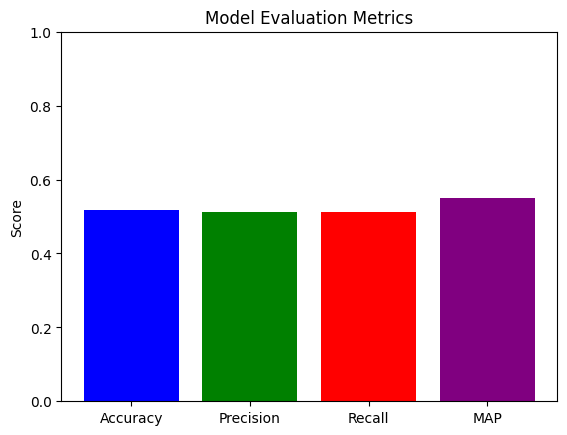

In [7]:
# Visualize the model evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'MAP']
values = [accuracy, precision, recall, map_score]

plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.ylim(0, 1)  # to set y-axis limits from 0 to 1
plt.show()


In [8]:
# Fine-tuning the model using Grid Search

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_clf = grid_search.best_estimator_


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.7s
[CV] END max_dep

In [9]:
# Feature importance

# importances = clf.feature_importances_
# for feature, importance in zip(['NDVI', 'NBR'], importances):
#     print(f"Feature: {feature}, Importance: {importance}")


Accuracy (Fine-tuned): 0.5661
Precision (Fine-tuned): 0.5596
Recall (Fine-tuned): 0.5578
Mean Average Precision (Fine-tuned): 0.5762
              precision    recall  f1-score   support

           0       0.53      0.47      0.49        86
           1       0.59      0.65      0.62       103

    accuracy                           0.57       189
   macro avg       0.56      0.56      0.56       189
weighted avg       0.56      0.57      0.56       189

[[40 46]
 [36 67]]


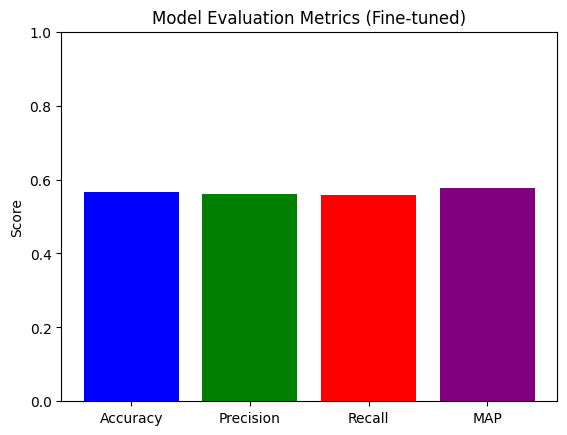

In [10]:
# Make predictions using the fine-tuned model
y_pred_best = best_clf.predict(X_test)

# Evaluate the fine-tuned model
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best, average='macro')
recall_best = recall_score(y_test, y_pred_best, average='macro')
map_score_best = average_precision_score(
    y_test, y_pred_best.reshape(-1, 1), average='macro')

print(f"Accuracy (Fine-tuned): {accuracy_best:.4f}")
print(f"Precision (Fine-tuned): {precision_best:.4f}")
print(f"Recall (Fine-tuned): {recall_best:.4f}")
print(f"Mean Average Precision (Fine-tuned): {map_score_best:.4f}")

print(classification_report(y_test, y_pred_best))
print(confusion_matrix(y_test, y_pred_best))

# Visualize the evaluation metrics for the fine-tuned model
metrics_best = ['Accuracy', 'Precision', 'Recall', 'MAP']
values_best = [accuracy_best, precision_best, recall_best, map_score_best]

plt.bar(metrics_best, values_best, color=['blue', 'green', 'red', 'purple'])
plt.ylabel('Score')
plt.title('Model Evaluation Metrics (Fine-tuned)')
plt.ylim(0, 1)
plt.show()
